In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import os
import glob
import importlib
import multiprocessing as mp
import itertools
import math
import random 

from matplotlib import pyplot as plt
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats
import scipy.spatial.distance as dist
import numpy as np
import h5py
from tqdm import tqdm
import pandas as pd
import tables
import deepdish as dd

sys.path.append('/Users/johnmarshall/Documents/MATLAB/CNMF_E/python_wrapper/')
sys.path.append('/Users/johnmarshall/caiman_data/demos/notebooks/post_cnmfe_analysis')
import python_utils as utils
import jjm_post_cnmfe_fns as jjm
import align_msCam_tobehavior as align_tracking

from importlib import reload
%matplotlib inline

In [ ]:
reload(align_tracking)

In [49]:
#GRIN013 
results_file = '/Users/johnmarshall/Documents/MATLAB/29-Apr_16_52_17_wsortdecisionsout.mat'
#GRIN011 #cnmfe_analysis_files/GRIN_011
#results_file = '/Users/johnmarshall/Documents/MATLAB/04-May_00_39_45_wsortdecisions_out.mat'

results = sio.loadmat(results_file)

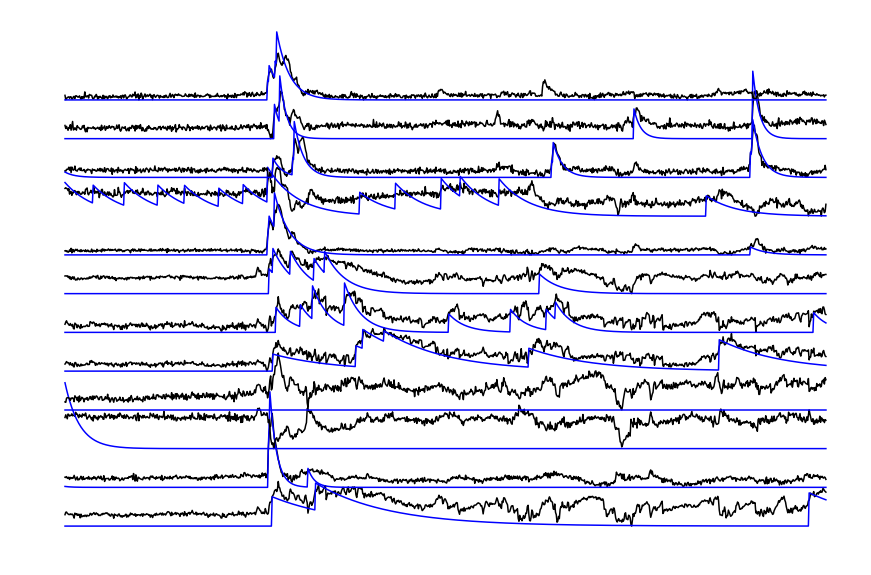

In [50]:
# Neurons to plot
neurons_idx = 10

# Frames to plot
frames = (0, 1000)

# Make a plot showing some time series traces

plt.figure(figsize=(15,10))
#plt.title(name)
plt.axis('off')
        
#S = np.array(results['S'].todense())  # Inferred spikes
C = np.array(results['C'])  # Denoised fluorescence
F = np.array(results['C_raw'])  # Raw fluorescence
        
for idx in range(np.shape(F)[0]):
    #plt.plot(utils.normalize(S[idx, frames[0]:frames[1]], percentile=False) + idx, 'r')
    plt.plot(utils.normalize(F[idx, frames[0]:frames[1]]) + idx, 'k')
    plt.plot(utils.normalize(C[idx, frames[0]:frames[1]]) + idx, 'b')
    if idx > neurons_idx:
        break

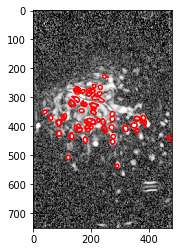

In [51]:
#coordinate of detected neurons 
coordinates = utils.plot_contours(results['A'].todense(), results['Cn'], display_numbers=False, maxthr=.6,cmap='gray', colors='r')

In [ ]:
##load movement data and align to cnmfe output

path_to_eztrackfiles = '/Volumes/My_Passport/MiniscopeMovies/3_9_2019/H13_M33_S54/behavCam/'
miniscope_time_stamp_file = path_to_eztrackfiles+'timestamp.dat'
location_files = glob.glob(path_to_eztrackfiles+'*_LocationOutput.csv')

dfs = []
for file in location_files:
     dfs.append(pd.read_csv(file, usecols=[1,9,10,11]))

tracking_concacted = pd.concat(dfs)

aligned_ = align_tracking.align_and_return_ezTrack(tracking_concacted, miniscope_time_stamp_file, 29000)
#plt.plot(aligned_['sys_clocks_behavCam']/(1000*60), aligned_['velocity'])

In [ ]:
## z score velocity trace 
# change infinity values to zero for now
velocity = aligned_['velocity'].values
velocity[velocity == np.inf] = 0
velocity_zscore = stats.zscore(velocity)
#plt.plot(aligned_['sys_clocks_behavCam']/(1000*60), velocity_zscore)

In [ ]:
## align fluorescence events to threshold crossing
event_count, sample_points = align_tracking.count_events_in_array_threshold(velocity_zscore, 30, 0, threshold=5, up=True)
# generate radom points for comparsion
random_points = random.sample(range(1, 29000), len(sample_points))
# velocity
velocity_averaged = align_tracking.return_triggered_events(velocity, sample_points, (300,300))
velocity_averaged_random = align_tracking.return_triggered_events(velocity, random_points, (300,300))
# denoised fluorescence 
C_mean = np.mean(C, axis=0)
denoised_fluorescence_averaged = align_tracking.return_triggered_events(C_mean, sample_points, (300,300))
denoised_fluorescence_averaged_random = align_tracking.return_triggered_events(C_mean, random_points, (300,300))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(velocity_averaged.mean(axis=1))
plt.subplot(2, 1, 2)
plt.plot(denoised_fluorescence_averaged.mean(axis=1))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(velocity_averaged_random.mean(axis=1))
plt.subplot(2, 1, 2)
plt.plot(denoised_fluorescence_averaged_random.mean(axis=1))

In [ ]:
## save output 
dd.io.save(results_file.rstrip('.mat')+'t.h5', {'C':results['C'],'C_raw':results['C_raw'],'A':results['A'], 'S':results['S'], 'behavior_info':aligned_.to_dict()})

In [ ]:
## should 1st Z - score velocity 

In [ ]:
num_neurons = np.shape(C)[0]

In [ ]:
## calculate distribution of correlation coefficents with velocity 
num_neurons = np.shape(C)[0]
behav_correlations = []
for neuron in range(1,num_neurons):
    r = stats.pearsonr(velocity_zscore, results['C'][neuron])[0]
    behav_correlations.append(r)

In [ ]:
hist_, bin_edges_ = np.histogram(behav_correlations, bins='auto')
plt.hist(behav_correlations, bins='auto')
plt.show()

In [52]:
## calculate pairwise correlation coefficients
num_neurons = np.shape(C)[0]
pairwise = {}
for pair in itertools.combinations(range(num_neurons),2):
    #pairwise correlation coefficient
    r = stats.pearsonr(results['C'][pair[0]], results['C'][pair[1]])[0]
    #euclidian distance 
    distance = dist.euclidean(coordinates[pair[0]]['CoM'], coordinates[pair[1]]['CoM'])
    pairwise[pair] = (r, distance)

In [53]:
pairwise[(0, 1)][0]

0.11310661173290901

In [54]:
r_coeffs = [pairwise[pair][0] for pair in list(pairwise.keys())]
distance = [pairwise[pair][1] for pair in list(pairwise.keys())]

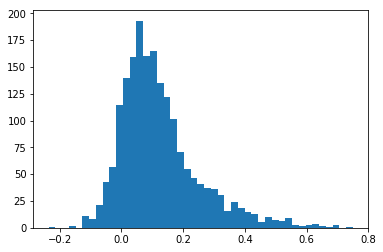

In [55]:
hist_, bin_edges_ = np.histogram(r_coeffs, bins='auto')
plt.hist(r_coeffs, bins='auto')
plt.show()

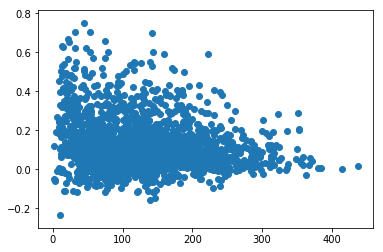

In [56]:
plt.scatter(distance, r_coeffs)
plt.show()

In [57]:
##save pairwise comparisons as hdf5 file 
pairwise_df = pd.DataFrame(pairwise)
pairwise_df.to_hdf('/Users/johnmarshall/Documents/MATLAB/29-Apr_16_52_17_pairwise_distance_comparisons.h5', key='df', mode='w', complevel=5)